In [91]:
# Import packages

import time
import re
import itertools

import pandas as pd
import numpy as np
#import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm

from dask import delayed, compute
from dask.distributed import Client

ModuleNotFoundError: No module named 'pmdarima'

In [2]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

### Import Data

In [3]:
%%time

# Read in 311 data
df_311 = pd.read_csv('Data/311_Service_Requests_20240430.csv',
                     index_col = 'Unique Key',
                     usecols = ['Agency','Borough','Complaint Type',
                              'Created Date','Incident Zip',#'Latitude','Longitude',
                              'Unique Key'],
                     dtype = {'Agency':'category','Borough':'category','Complaint Type':str,
                              'Created Date':str,'Incident Zip':str,#'Latitude':float,'Longitude':float,
                              'Unique Key':'int64'})

# Rename columns
df_311.rename({'Complaint Type': 'Type', 'Created Date': 'Date', 'Incident Zip': 'Zip'}, axis=1, inplace=True)

CPU times: total: 3min 16s
Wall time: 3min 22s


In [4]:
# Read in NYC weather data, and format

df_weather = pd.read_csv('Data/NYC_weather_data.csv')
df_weather.drop_duplicates(inplace=True)
df_weather.drop('Unnamed: 0', axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date']).values.astype('datetime64[D]')
df_weather.set_index('date',inplace=True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10466 entries, 2010-01-01 to 2024-04-30
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   weather_code         int64  
 1   temperature_2m_max   float64
 2   temperature_2m_min   float64
 3   temperature_2m_mean  float64
 4   daylight_duration    float64
 5   rain_sum             float64
 6   snowfall_sum         float64
 7   wind_speed_10m_max   float64
dtypes: float64(7), int64(1)
memory usage: 735.9 KB


In [5]:
# Read in NYC zip codes

df_zip = pd.read_csv('Data/uszips/uszips.csv',
                     index_col = 'zip',
                     dtype = {'borough': str, 'zip': str} )

In [6]:
# Load shapefile of zip codes
#filtered_shapefile_path = 'Data/USA_ZIP_Code_Boundaries/filtered_zip_code_shapefile.shp'
#filtered_zip_codes_gdf = gpd.read_file(filtered_shapefile_path)

### Drop unusable rows

In [7]:
print(f'Initial items: {len(df_311):,.0f}')

Initial items: 36,217,243


In [8]:
# Drop rows with no useable location data
no_loc = df_311['Zip'].isna() #& df_311['Latitude'].isna()
df_311 = df_311[~no_loc]
print(f'Rows with locations: {len(df_311):,.0f}')

Rows with locations: 34,682,301


In [9]:
%%time
# Convert date columns to datetime, dropping time component and dropping dates after March 31, 2024
date_format = '%m/%d/%Y %I:%M:%S %p'
df_311['Date'] = pd.to_datetime(df_311['Date'], format=date_format).values.astype('datetime64[D]')
df_311 = df_311[df_311['Date'] < pd.Timestamp('2024-04-01')]
print(f'Rows in the date range: {len(df_311):,.0f}')

Rows in the date range: 34,435,921
CPU times: total: 2min 29s
Wall time: 2min 31s


In [10]:
# Convert NaN values in 'Incident Zip' to 'empty', to simplify further processing
df_311['Zip'] = df_311['Zip'].fillna('empty')
df_311.isna().sum()

# Clean up ZIP codes by removing '-####' if present
df_311['Zip'] = df_311['Zip'].str.replace(r'-\d{4}$', '', regex=True)

# Drop all rows with zip codes not in NYC
df_311 = df_311[df_311['Zip'].isin(df_zip.index)]
print(f'Rows in NYC: {len(df_311):,.0f}')

Rows in NYC: 34,388,549


In [11]:
# Fill in latitude and longitude when a zip code is available

# Latitude and longitude from US Zip Code file
#zip_to_lat = df_zip['lat'].to_dict()
#zip_to_lng = df_zip['lng'].to_dict()

# Fill in missing latitude and longitude using the mapping, but only if values don't already exist
#df_311.loc[df_311['Latitude'].isna(), 'Latitude'] = df_311['Zip'].map(zip_to_lat)
#df_311.loc[df_311['Longitude'].isna(), 'Longitude'] = df_311['Zip'].map(zip_to_lng)

#### Consolidate Agencies and Types

In [12]:
# Consolidate agencies, replacing minor agencies with 'Other'
agency_dict = {
    'NYPD': 'Police',
    'HPD': 'Housing',
    'DSNY': 'Sanitation',
    'DOT': 'Transportation',
    'DEP': 'Environment',
    'DOB': 'Buildings',
    'DPR': 'Parks',
    'DOMHM': 'Health',
    'DOF': 'Finance',
    'TLC': 'Taxi',
    'DHS': 'Homeless',
    'DCA': 'Consumer',
    'DEPARTMENT OF CONSUMER AND WORKER PROTECTION': 'Consumer',
    'EDC': 'Development',
    'HRA': 'Human Resources',
    'DFTA': 'Aging',
    'OSE': 'ST Rentals',
}

df_311['Agency'] = df_311['Agency'].map(agency_dict).fillna('Other')

In [13]:
# Convert all line items to lowercase
df_311['Type'] = df_311['Type'].str.lower()

In [14]:
# Convert complaint types to fewer categories
complaint_dict = {
    'noise - residential': 'Noise',
    'illegal parking': 'Vehicle',
    'heat/hot water': 'Resident Utility',
    'blocked driveway': 'Vehicle',
    'street condition': 'Street Condition',
    'noise - street/sidewalk': 'Noise',
    'street light condition': 'Traffic Device',
    'request large bulky item collection': 'Item Pickup',
    'plumbing': 'Resident Utility',
    'heating': 'Resident Utility',
    'water system': 'Resident Utility',
    'unsanitary condition': 'Sanitation',
    'noise': 'Noise',
    'general construction/plumbing': 'Resident Utility',
    'traffic signal condition': 'Traffic Device',
    'noise - commercial': 'Noise',
    'paint/plaster': 'Buildings',
    'noise - vehicle': 'Noise',
    'general construction': 'Construction',
    'sewer': 'Sewer',
    'damaged tree': 'Tree',
    'rodent': 'Sanitation',
    'dirty conditions': 'Sanitation',
    'electric': 'Resident Utility',
    'derelict vehicles': 'Vehicle',
    'sanitation condition': 'Sanitation',
    'door/window': 'Buildings',
    'paint - plaster': 'Buildings',
    'sidewalk condition': 'Street Condition',
    'water leak': 'Resident Utility',
    'building/use': 'Buildings',
    'missed collection (all materials)': 'Sanitation',
    'literature request': 'Other',
    'consumer complaint': 'Consumer',
    'general': 'Other',
    'homeless person assistance': 'Social Services',
    'nonconst': 'Other',
    'abandoned vehicle': 'Vehicle',
    'new tree request': 'Tree',
    'flooring/stairs': 'Buildings',
    'graffiti': 'Quality of Life',
    'overgrown tree/branches': 'Tree',
    'non-emergency police matter': 'Police',
    'derelict vehicle': 'Vehicle',
    'maintenance or facility': 'Other',
    'taxi complaint': 'Taxi',
    'appliance': 'Buildings',
    'elevator': 'Buildings',
    'broken muni meter': 'Parking',
    'missed collection': 'Sanitation',
    'noise - helicopter': 'Noise',
    'root/sewer/sidewalk condition': 'Street Condition',
    'food establishment': 'Vendors',
    'for hire vehicle complaint': 'Taxi',
    'dirty condition': 'Sanitation',
    'air quality': 'Environmental',
    'benefit card replacement': 'Social Services',
    'encampment': 'Social Services',
    'dof property - reduction issue': 'Finance',
    'lead': 'Public Health',
    'safety': 'Other',
    'street sign - damaged': 'Traffic Device',
    'illegal fireworks': 'Quality of Life',
    'snow': 'Snow',
    'electronics waste appointment': 'Item Pickup',
    'scrie': 'Housing',
    'dead/dying tree': 'Tree',
    'illegal dumping': 'Sanitation',
    'broken parking meter': 'Parking',
    'other enforcement': 'Police',
    'dof parking - payment issue': 'Finance',
    'indoor air quality': 'Buildings',
    'noise - park': 'Noise',
    'curb condition': 'Street Condition',
    'street sign - missing': 'Traffic Device',
    'noncompliance with phased reopening': 'Public Health',
    'dof property - owner issue': 'Finance',
    'traffic': 'Traffic Device',
    'dof property - request copy': 'Finance',
    'highway condition': 'Street Condition',
    'dead tree': 'Tree',
    'emergency response team (ert)': 'Buildings',
    'special projects inspection team (spit)': 'Construction',
    'water conservation': 'Parks and Rec',
    'dof property - payment issue': 'Finance',
    'hpd literature request': 'Housing',
    'animal abuse': 'Animal',
    'housing - low income senior': 'Housing',
    'drug activity': 'Police',
    'vending': 'Quality of Life',
    'electrical': 'Resident Utility',
    'illegal tree damage': 'Tree',
    'dhs advantage - tenant': 'Housing',
    'food poisoning': 'Public Health',
    'street sign - dangling': 'Traffic Device',
    'violation of park rules': 'Parks and Rec',
    'homeless encampment': 'Social Services',
    'smoking': 'Public Health',
    'animal-abuse': 'Animal',
    'animal in a park': 'Animal',
    'hazardous materials': 'Environmental',
    'obstruction': 'Vehicle',
    'construction': 'Construction',
    'lost property': 'Other',
    'litter basket / request': 'Sanitation',
    'boilers': 'Resident Utility',
    'construction safety enforcement': 'Construction',
    'dhs advantage -landlord/broker': 'Housing',
    'unsanitary animal pvt property': 'Animal',
    'drinking': 'Social Services',
    'residential disposal complaint': 'Sanitation',
    'standing water': 'Environmental',
    'electronics waste': 'Item Pickup',
    'panhandling': 'Social Services',
    'dca / doh new license application request': 'Vendors',
    'asbestos': 'Buildings',
    'dead animal': 'Animal',
    'dof property - update account': 'Finance',
    'outdoor dining': 'Vendors',
    'best/site safety': 'Construction',
    'street sweeping complaint': 'Street Condition',
    'water quality': 'Resident Utility',
    'vendor enforcement': 'Vendors',
    'real time enforcement': 'Buildings',
    'housing options': 'Housing',
    'bus stop shelter complaint': 'Social Services',
    'industrial waste': 'Environmental',
    'bike/roller/skate chronic': 'Quality of Life',
    'mobile food vendor': 'Vendors',
    'overflowing litter baskets': 'Sanitation',
    'derelict bicycle': 'Vehicle',
    'noise survey': 'Noise',
    'non-residential heat': 'Buildings',
    'miscellaneous categories': 'Other',
    'homeless street condition': 'Social Services',
    'noise - house of worship': 'Noise',
    'taxi report': 'Taxi',
    'traffic/illegal parking': 'Vehicle',
    'unleashed dog': 'Animal',
    'indoor sewage': 'Resident Utility',
    'outside building': 'Other',
    'snow or ice': 'Snow',
    'dof parking - request status': 'Finance',
    'unsanitary pigeon condition': 'Animal',
    'sweeping/missed': 'Street Condition',
    'dof parking - request copy': 'Finance',
    'recycling enforcement': 'Sanitation',
    'dpr internal': 'Parks and Rec',
    'urinating in public': 'Social Services',
    'litter basket request': 'Sanitation',
    'day care': 'Social Services',
    'illegal posting': 'Quality of Life',
    'borough office': 'Other',
    'sanitation worker or vehicle complaint': 'Sanitation',
    'vaccine mandate non-compliance': 'Public Health',
    'covid-19 non-essential construction': 'Construction',
    'building marshals office': 'Buildings',
    'commercial disposal complaint': 'Sanitation',
    'dof parking - tax exemption': 'Finance',
    'bridge condition': 'Street Condition',
    'sustainability enforcement': 'Sanitation',
    'taxi compliment': 'Taxi',
    'elder abuse': 'Social Services',
    'sweeping/missed-inadequate': 'Street Condition',
    'disorderly youth': 'Social Services',
    'abandoned bike': 'Vehicle',
    'mold': 'Buildings',
    'dumpster complaint': 'Sanitation',
    'illegal animal kept as pet': 'Animal',
    'mosquitoes': 'Environmental',
    'for hire vehicle report': 'Taxi',
    'drie': 'Housing',
    'found property': 'Other',
    'home delivered meal - missed delivery': 'Social Services',
    'litter basket complaint': 'Sanitation',
    'construction lead dust': 'Environmental',
    'mass gathering complaint': 'Quality of Life',
    'cranes and derricks': 'Construction',
    'dof property - rpie issue': 'Finance',
    'posting advertisement': 'Quality of Life',
    'home repair': 'Buildings',
    'harboring bees/wasps': 'Animal',
    'scaffold safety': 'Construction',
    'adopt-a-basket': 'Sanitation',
    'senior center complaint': 'Social Services',
    'plant': 'Other',
    'window guard': 'Buildings',
    'sewer maintenance': 'Sewer',
    'snow removal': 'Snow',
    'sweeping/inadequate': 'Street Condition',
    "alzheimer's care": 'Social Services',
    'beach/pool/sauna complaint': 'Parks and Rec',
    'city vehicle placard complaint': 'Other',
    'drinking water': 'Resident Utility',
    'collection truck noise': 'Sanitation',
    'question': 'Other',
    'facades': 'Buildings',
    'private or charter school reopening': 'Public Health',
    'dof property - property value': 'Finance',
    'dof parking - dmv clearance': 'Finance',
    'request xmas tree collection': 'Item Pickup',
    'poison ivy': 'Environmental',
    'oem disabled vehicle': 'Vehicle',
    'uprooted stump': 'Tree',
    'wood pile remaining': 'Construction',
    'face covering violation': 'Public Health',
    'tattooing': 'Other',
    'heap assistance': 'Resident Utility',
    'highway sign - damaged': 'Traffic Device',
    'quality of life': 'Quality of Life',
    'utility program': 'Resident Utility',
    'executive inspections': 'Buildings',
    'forms': 'Other',
    'dhs advantage - third party': 'Public Health',
    'unsanitary animal facility': 'Vendors',
    'green taxi complaint': 'Taxi',
    'dof property - city rebate': 'Finance',
    'forensic engineering': 'Buildings',
    'weatherization': 'Buildings',
    'pet shop': 'Vendors',
    'animal facility - no permit': 'Vendors',
    'special natural area district (snad)': 'Parks and Rec',
    'municipal parking facility': 'Parking',
    'home delivered meal complaint': 'Social Services',
    'illegal animal sold': 'Animal',
    'seasonal collection': 'Item Pickup',
    'dep street condition': 'Street Condition',
    'stalled sites': 'Other',
    'advocate-personal exemptions': 'Finance',
    'highway sign - missing': 'Traffic Device',
    'ahv inspection unit': 'Vendors',
    'e-scooter': 'Quality of Life',
    'public toilet': 'Parks and Rec',
    'eviction': 'Housing',
    'fatf': 'Finance',
    'dof parking - address update': 'Parking',
    'advocate-prop refunds/credits': 'Finance',
    'water maintenance': 'Resident Utility',
    'highway sign - dangling': 'Traffic Device',
    'parking card': 'Parking',
    'taxpayer advocate inquiry': 'Finance',
    'summer camp': 'Parks and Rec',
    'special operations': 'Quality of Life',
    'incorrect data': 'Other',
    'bereavement support group': 'Social Services',
    'advocate - other': 'Social Services',
    'lifeguard': 'Parks and Rec',
    'squeegee': 'Quality of Life',
    'x-ray machine/equipment': 'Other',
    'home care provider complaint': 'Social Services',
    'case management agency complaint': 'Social Services',
    'atf': 'Police',
    'private school vaccine mandate non-compliance': 'Public Health',
    'overflowing recycling baskets': 'Sanitation',
    'comments': 'Other',
    'cooling tower': 'Buildings',
    'recycling basket complaint': 'Sanitation',
    'calorie labeling': 'Vendors',
    'legal services provider complaint': 'Social Services',
    'health': 'Public Health',
    'radioactive material': 'Environmental',
    'dhs income savings requirement': 'Housing',
    'institution disposal complaint': 'Sanitation',
    'water drainage': 'Environmental',
    'green taxi report': 'Taxi',
    'peeling paint': 'Buildings',
    'tunnel condition': 'Street Condition',
    'building drinking water tank': 'Buildings',
}    

In [15]:
df_311['Type'] = df_311['Type'].map(complaint_dict).fillna('Other')

#### Quick Visualizations

In [16]:
# Clean Borough values for charting
df_311['Borough'] = df_311['Borough'].str.title()

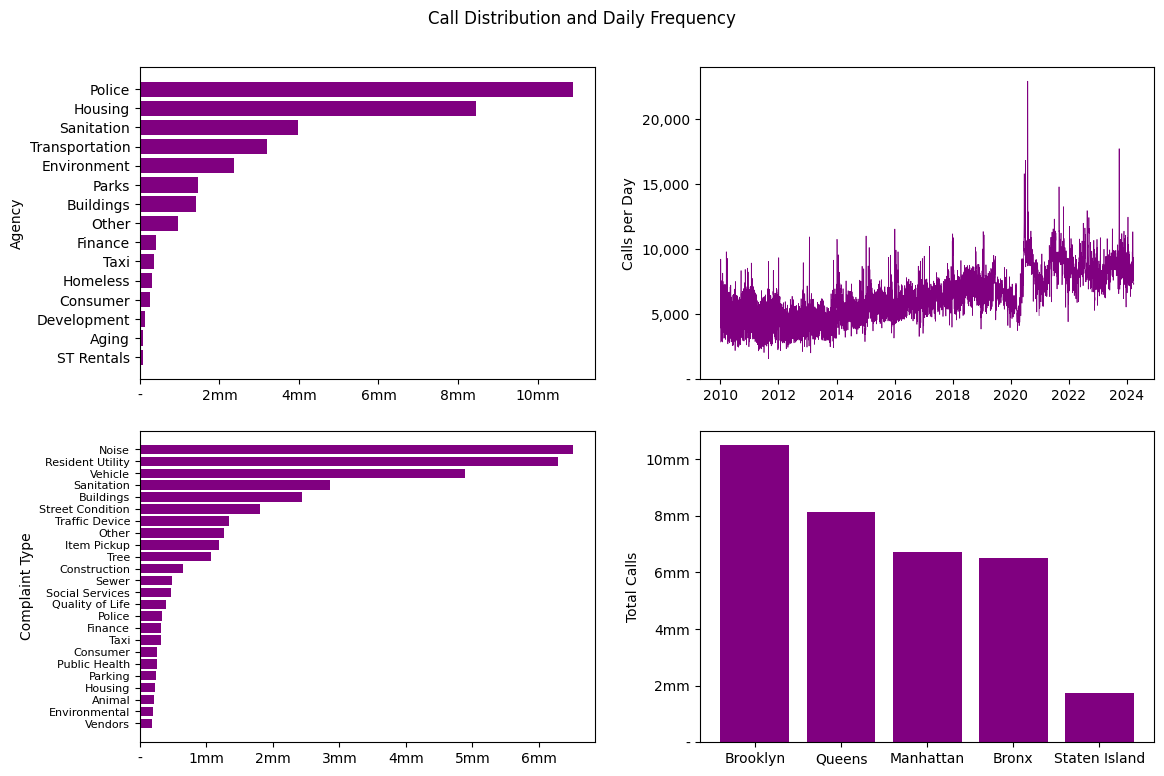

In [17]:
# Visualize call data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Call Distribution and Daily Frequency')
ax1.barh(y = df_311['Agency'].value_counts().sort_values(ascending=True).index[1:], width = df_311['Agency'].value_counts().sort_values(ascending=True)[1:], color='purple')
ax1.set_xticks([0,2000000,4000000,6000000,8000000,10000000])
ax1.set_xticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax1.set_ylabel('Agency')
ax2.plot(df_311['Date'].value_counts().sort_index(), linewidth=0.5, color='purple')
ax2.set_yticks([0,5000,10000,15000,20000])
ax2.set_yticklabels(['-','5,000','10,000','15,000','20,000'])
ax2.set_ylabel('Calls per Day')
ax3.barh(y= df_311['Type'].value_counts().sort_values(ascending=True).index[2:], width = df_311['Type'].value_counts().sort_values(ascending=True)[2:], color='purple')
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xticks([0,1000000,2000000,3000000,4000000,5000000,6000000])
ax3.set_xticklabels(['-','1mm','2mm','3mm','4mm','5mm','6mm'])
ax3.set_ylabel('Complaint Type')
ax4.bar(x=df_311['Borough'].value_counts().sort_values(ascending=False)[:-1].index, height=df_311['Borough'].value_counts().sort_values(ascending=False)[:-1], color='purple')
ax4.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
ax4.set_yticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax4.set_ylabel('Total Calls')
plt.tight_layout(pad=2.0)
plt.show()

### Weather

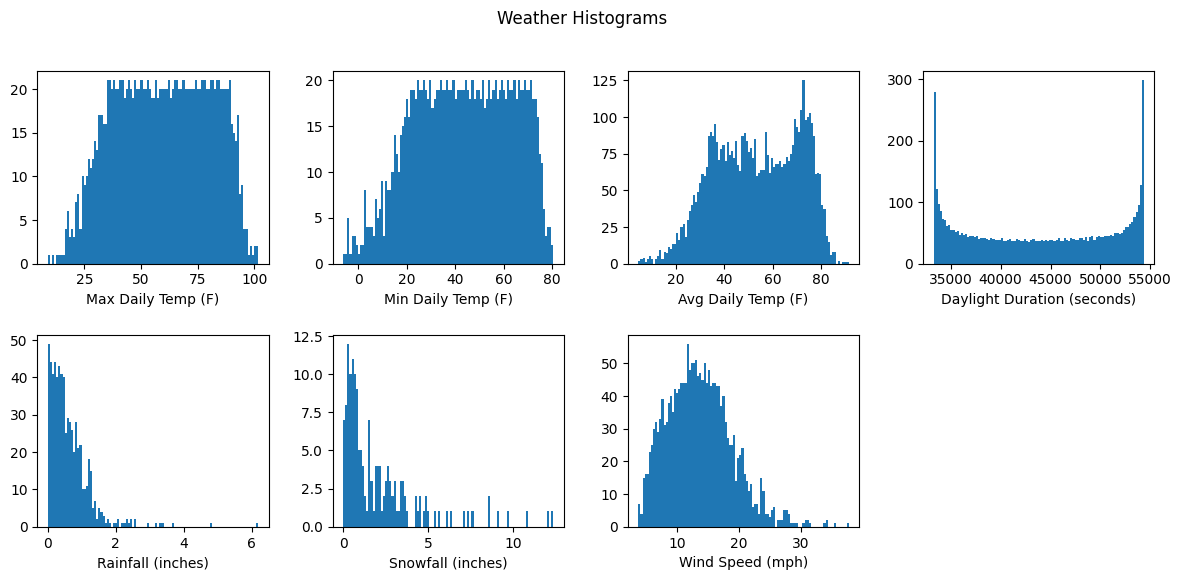

In [18]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')
ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall and snowfall: Log Transform, but remember to add a small constant to avoid taking log of zero, then consider minmax scale [0,1] the result
- Wind speed: Log Transform, but probably no need to add small constant
- Temperatures - Seasonal decompose first, then minmax scale, then seasonal recompose
- Daylight Duration - Minmax scaling

# Modeling
- Perform Baseline model, 1 day shift (equal to ARIMA(0,1,0))
- Step up to ARIMA model to see if performance can be improved
- Search for seasonality (weekly and annually) and apply SARIMA if found
- SARIMA can only handle one dimension of seasonality, consider TBATs for more than one period
  

### Baseline Model

In [62]:
# Test-Train Split for Baseline Model
df_311_agg = df_311.drop(columns=['Borough','Agency','Type','Zip'], axis=1)
df_311_pivot = df_311_agg.groupby('Date').size().reset_index(name='Count')
df_311_pivot.set_index('Date', inplace=True)
df_311_pivot['Pred_Baseline'] = df_311_pivot['Count'].shift(1)
df_311_pivot = df_311_pivot.asfreq('D')

split_point = int(len(df_311_pivot) * 0.8)

baseline_train_df = df_311_pivot.iloc[:split_point]  # About 80%
baseline_test_df = df_311_pivot[split_point:]   # About 20%

In [64]:
# Implement ARIMA(0, 1, 0) model (Baseline comparison)
baseline_model = ARIMA(baseline_train_df['Count'], order=(0, 1, 0))
baseline_results = baseline_model.fit()

# Forecast using the ARIMA(0, 1, 0) model
baseline_pred = baseline_results.get_forecast(steps=len(baseline_test_df))
baseline_y_pred = baseline_pred.predicted_mean

# Calculate evaluation metrics for baseline ARIMA(0, 1, 0) model
baseline_mae = mean_absolute_error(baseline_test_df['Count'], baseline_y_pred)
baseline_mape = mean_absolute_percentage_error(baseline_test_df['Count'], baseline_y_pred)
baseline_mse = mean_squared_error(baseline_test_df['Count'], baseline_y_pred)
baseline_rmse = np.sqrt(baseline_mse)

# Print baseline model evaluation metrics
print('Performance: Baseline Model')
print('-------------------------')
print(f'MAE: {baseline_mae}')
print(f'MAPE: {baseline_mape:.4f}')
print(f'MSE: {baseline_mse}')
print(f'RMSE: {baseline_rmse}')

Performance: Baseline Model
-------------------------
MAE: 959.418828049952
MAPE: 0.1160
MSE: 1598963.576368876
RMSE: 1264.5013152895003


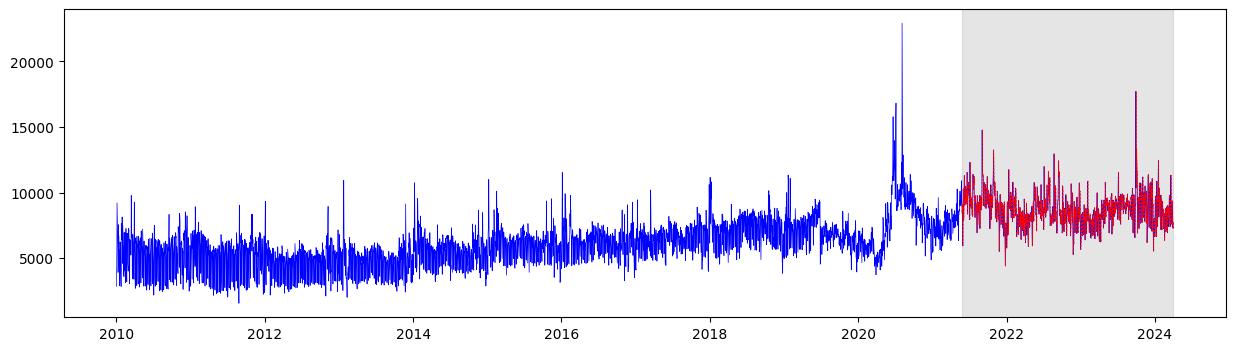

In [65]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(baseline_train_df['Count'], 'b-', label='Historic', linewidth=0.5)
ax.plot(baseline_test_df['Count'], 'b-', label='Actual', linewidth=0.5)
ax.plot(baseline_test_df['Pred_Baseline'], 'r--', label='Prediction: 1-day shift', linewidth=0.5)
ax.axvspan(pd.Timestamp('2021-05-26'),pd.Timestamp('2024-03-31'), color='#808080', alpha=0.2)
plt.show()

### First Simple Model: ARIMA

First, test for stationarity:

In [66]:
result = adfuller(df_311_pivot['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.520885912394666
p-value: 0.11047490316084041


<b><span style="color:red">Not stationary</span></b>  
Because the p-value of the ADF statistics is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [68]:
# Transform the data by taking the one-day difference
df_311_pivot['Count_diff'] = df_311_pivot['Count'].diff().dropna()
result_diff = adfuller(df_311_pivot['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.567541398065114
p-value (1st diff): 0.0


<b><span style="color:green">Stationary</span></b>  
The data is now stationary.  First, plot ACF and PACF to look for good p and q terms, and check for seasonality. 

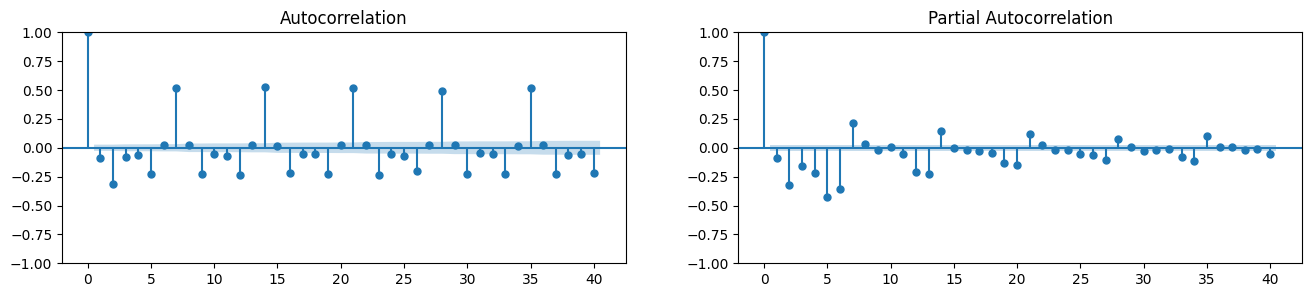

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(df_311_pivot['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(df_311_pivot['Count_diff'].dropna(), lags=40, ax=axes[1]);

Drops off after 1 term, probably means p=1 and q=1.  Since d already equals 1, this means the ideal order is probably (1, 1, 1).  
Also looks like seasonality, which we'll explore later.  

In [60]:
# Split into train and test sets
arima_train_df = df_311_pivot.iloc[:split_point]
arima_test_df = df_311_pivot.iloc[split_point:]

# Specify all iterations of pdq
p = d = q = range(0, 2)
arima_pdq = list(itertools.product(p, d, q))

# Function to fit ARIMA and calculate AIC
def fit_arima(train, param):
    try:
        model = ARIMA(train, order=param)
        results = model.fit()
        return results.aic, results
    except Exception as e:
        return np.inf, None

# Grid search
best_aic = np.inf
best_pdq = None
best_model = None

for param in arima_pdq:
    aic, model = fit_arima(arima_train_df['Count'], param)
    if aic < best_aic:
        arima_best_aic = aic
        arima_best_pdq = param
        arima_best_model = model

print(f'Best ARIMA model: {arima_best_pdq} with AIC {arima_best_aic}')

Best ARIMA model: (1, 1, 1) with AIC 69895.4826586303


As expected, p, d, q = (1, 1, 1) is the best model.  Next, test this model against the baseline.

In [61]:
# Forecast using the best model
pred = arima_best_model.get_forecast(steps=len(arima_test_df))
pred_ci = pred.conf_int()

# Calculate evaluation metrics
y_pred = pred.predicted_mean
arima_mae = mean_absolute_error(arima_test_df['Count'], y_pred)
arima_mape = mean_absolute_percentage_error(arima_test_df['Count'], y_pred)
arima_mse = mean_squared_error(arima_test_df['Count'], y_pred)
arima_rmse = np.sqrt(arima_mse)

# Print evaluation metrics
print('ARIMA errors')
print('-------------------------')
print(f'MAE: {arima_mae}')
print(f'MAPE: {arima_mape:.4f}')
print(f'MSE: {arima_mse}')
print(f'RMSE: {arima_rmse}')

ARIMA errors
-------------------------
MAE: 937.6739564797484
MAPE: 0.1096
MSE: 1547592.4493839252
RMSE: 1244.0226884522344


Improvement  
This model outperforms the baseline, but only slightly  
Explore seasonality for SARIMA model

### SARIMA for seasonality
- There seems to be a clear 7 day cycle, seen in the ACF/PACF plots above
- Verify the difference by plotting day-frequency

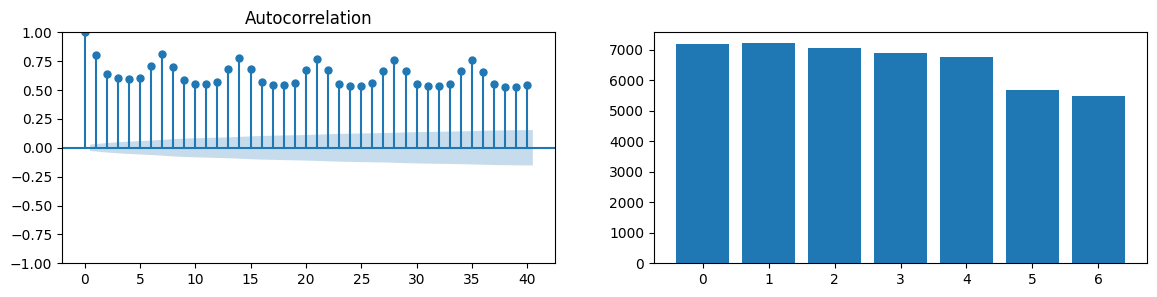

In [86]:
df_311_pivot['day_of_week'] = df_311_pivot.index.dayofweek

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 3))
plot_acf(df_311_pivot['Count'].dropna(), lags=40, ax=ax1)
ax2.bar(x = df_311_pivot['Count'].groupby(df_311_pivot['day_of_week']).mean().index, height = df_311_pivot['Count'].groupby(df_311_pivot['day_of_week']).mean())

plt.show()

No doubt about the 7-day cycle  
Strip out that effect and look for 30 day or 365 day

In [87]:
# Seasonal decomposition to remove weekly seasonality (7 days)
decomposition = seasonal_decompose(df_311_pivot['Count'], period=7)
residuals = decomposition.resid.dropna()

ADF Statistic (seasonal diff): -17.244079097201197
p-value (seasonal diff): 6.0813615759671284e-30


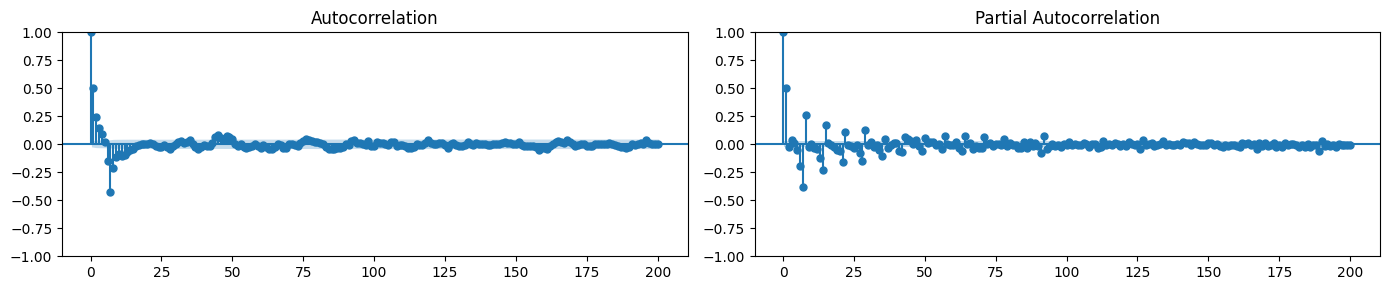

In [88]:
df_311_pivot['Count_seasonal_diff'] = df_311_pivot['Count'].diff(7).dropna()

# Verify stationarity of the seasonally differenced series
result_seasonal_diff = adfuller(df_311_pivot['Count_seasonal_diff'].dropna())
print(f'ADF Statistic (seasonal diff): {result_seasonal_diff[0]}')
print(f'p-value (seasonal diff): {result_seasonal_diff[1]}')

# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
plot_acf(df_311_pivot['Count_seasonal_diff'].dropna(), ax=ax[0], lags=200)
plot_pacf(df_311_pivot['Count_seasonal_diff'].dropna(), ax=ax[1], lags=200)
plt.tight_layout()
plt.show()

Does not look like there is a specific 30 day cycle.  Because the initial spikes are so large, there's clearly an AR component to the data.  
Regenerate the same chart, but with 800 lags to detect an annual cycle.

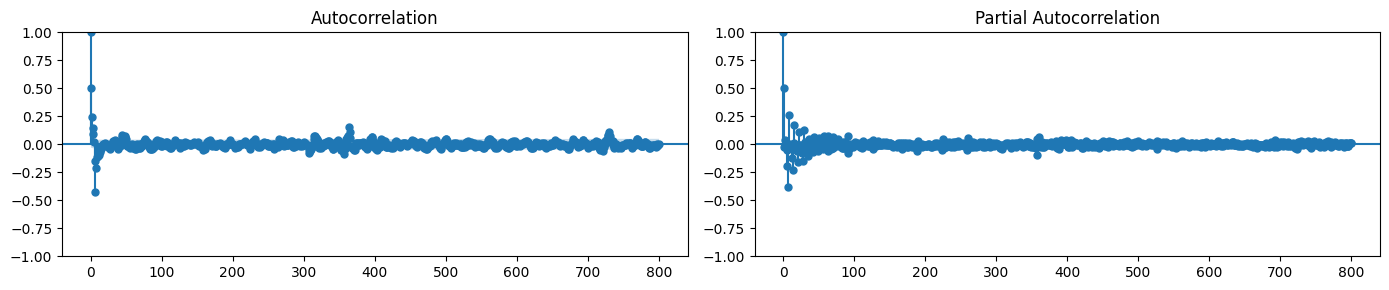

In [89]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
plot_acf(df_311_pivot['Count_seasonal_diff'].dropna(), ax=ax[0], lags=800)
plot_pacf(df_311_pivot['Count_seasonal_diff'].dropna(), ax=ax[1], lags=800)
plt.tight_layout()
plt.show()

Modest annual effect.  SARIMA can only handle one seasonal effect at a time.  We may need to explore other models after SARIMA.  For now, proceed with SARIMA.  
Use seasonal decomposition to visually inspect for parameters

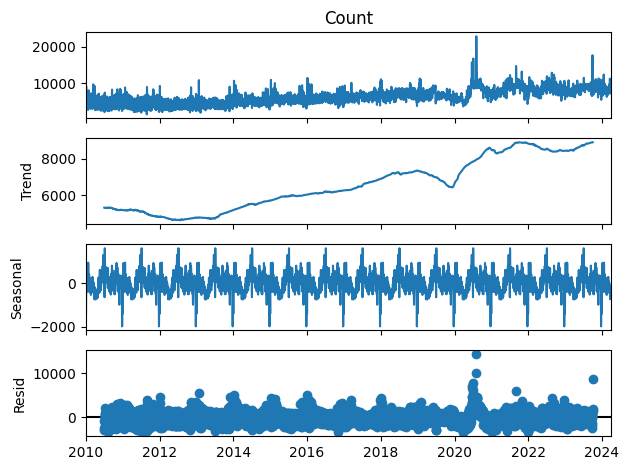

In [94]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_311_pivot['Count'], period=365)
decomposition.plot()
plt.show()

There is a clear 365 day effect here too.  We will eventually need to tackle both the 7 day and 365 day cycles.  
But first, we'll take a look at ACF/PACF of the seasonal difference, to determine whether there are some likely  
parameters.

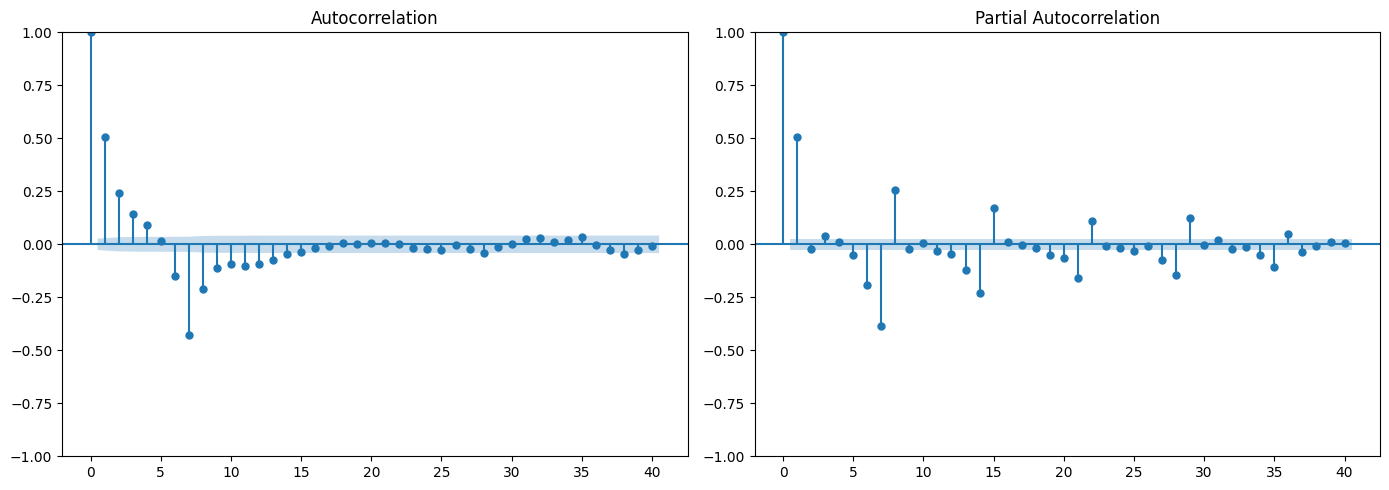

In [95]:
# Seasonal differencing
df_311_pivot['Count_seasonal_diff'] = df_311_pivot['Count'].diff(7).dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df_311_pivot['Count_seasonal_diff'].dropna(), lags=40, ax=ax[0])
plot_pacf(df_311_pivot['Count_seasonal_diff'].dropna(), lags=40, ax=ax[1])
plt.tight_layout()
plt.show()


In [96]:
#Recreate train-test split
sarima_train_df = df_311_pivot[:split_point]
sarima_test_df = df_311_pivot[split_point:]

In [102]:
sarima_model = SARIMAX(sarima_train_df['Count'], 
                       order=(1, 1, 1), 
                       seasonal_order=(2, 1, 1, 7),
                       enforce_stationarity=True, 
                       enforce_invertibility=True)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results)

In [103]:
# Forecast using the SARIMA model
sarima_pred = sarima_results.get_forecast(steps=len(sarima_test_df))
y_pred = sarima_pred.predicted_mean

# Calculate evaluation metrics
sarima_mae = mean_absolute_error(sarima_test_df['Count'], y_pred)
sarima_mape = mean_absolute_percentage_error(sarima_test_df['Count'], y_pred)
sarima_mse = mean_squared_error(sarima_test_df['Count'], y_pred)
sarima_rmse = np.sqrt(sarima_mse)

# Print evaluation metrics
print('SARIMA model errors')
print('-------------------------')
print(f'MAE: {sarima_mae}')
print(f'MAPE: {sarima_mape:.4f}')
print(f'MSE: {sarima_mse}')
print(f'RMSE: {sarima_rmse}')

SARIMA model errors
-------------------------
MAE: 974.5790701493302
MAPE: 0.1149
MSE: 1661675.9131371093
RMSE: 1289.0600890327453


In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_311_pivot.index, df_311_pivot['Count'], label='Observed')
plt.plot(sarima_test_df.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(sarima_test_df.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

### SEASONALITY
- Clear 7-day seasonality, 

In [ ]:
plot_acf(df_311_pivot['Count'].dropna(), lags=365)  # Set lags to cover multiple cycles
plt.title('ACF Plot')
plt.show()

In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(df_311_pivot['Count'], model='additive', period=7)
result.plot()
plt.show()

In [ ]:
advanced_decomposition = STL(df_311_pivot['Count'], period=91).fit()

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.tight_layout()

In [ ]:
from scipy.signal import periodogram

frequencies, spectrum = periodogram(df_311_pivot['Count'].dropna())
plt.plot(frequencies, spectrum)
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Periodogram')
plt.show()